## 3. Backtesting Futures Trading Strategies
This project uses Zipline Reloaded as the backtesting engine. Originally developed by Quantopian and later maintained by the opensource community, Zipline remains one of the few Python-based frameworks capable of handling multi-asset, long-horizon futures strategies. Its design allows for memory-efficient simulations, as data is read incrementally rather than fully loaded into memory — an essential feature when testing strategies across large universes of contracts.

Zipline introduces two central concepts for data handling: bundles and ingestion. A bundle is Zipline’s internal data format, optimized for both speed and memory usage. Rather than storing data in raw CSV or API driven formats, bundles provide structured and compressed access. This is especially important when working with futures data, which spans hundreds of contracts and multiple rollovers. Without such efficiency, long-term simulations would become computationally infeasible.

To use a bundle, the dataset must first be ingested. Ingestion is the one-time process of converting an external dataset (e.g., CSVs, commercial feeds like Norgate, CSI Data, or Quandl) into Zipline’s binary format. This step requires all metadata to be carefully structured in advance, including contract specifications, and benchmark definitions. If this process is mishandled, backtest results can become unreliable.

Reliability then comes down to data quality and coverage:

- Data quality ensures that historical prices are clean, consistent, and correctly adjusted. Errors such as missing values, mispriced ticks, or faulty rollovers can lead to false trading signals.
- Coverage determines whether the dataset includes the necessary breadth of markets, sufficient historical depth, and correctly structured contract rollovers.

For this project, we use the Norgate Data futures subscription because it satisfies both requirements. It provides survivorship-bias-free historical data for equities, futures, and FX. Its daily frequency is sufficient for the models developed here.

To integrate Norgate with Zipline, a custom bundle is registered in the local extension.py file:

https://pypi.org/project/norgatedata/
https://pypi.org/project/zipline-norgatedata/

In [ ]:
from zipline_norgatedata import register_norgatedata_futures_bundle

register_norgatedata_futures_bundle(
    bundlename='norgatedata-full-futures',
    session_symbols=['ES', 'NKD', 'NQ', 'HTW', 'YM'],  # Symbols example 
    symbol_list=['$SPXTR'],  # Benchmark
    start_session='2000-01-03'
)

Once the configuration is saved, ingestion is triggered from the terminal:



In [ ]:
zipline ingest -b norgatedata-full-futures


This process parses the dataset into Zipline’s internal format, enabling fast and memory-efficient backtests across a large set of futures contracts. With this setup complete, the research environment is ready for systematic strategy trading.

## 4. Futures Basics
Before moving deeper into backtesting and model design, it is important to review the asset class at the core of this project: futures.

Futures are standardized contracts to buy or sell an underlying asset at a predetermined price on a specific future date. While they were originally designed for hedging purposes—such as farmers locking in crop prices—today, most trading volume is driven by speculators and financial participants.

For systematic traders, the appeal of futures lies in their uniform structure. Whether trading oil, corn, bonds, or equity indices, the contract mechanics remain the same. This consistency allows a single infrastructure to scale across asset classes: one framework, many markets. Development, execution, and risk management therefore become more streamlined and robust.

From a textbook perspective, futures contracts require physical delivery of the underlying at expiry. In practice, however, physical settlement is rare. Many contracts are cash-settled, and for those that are physically settled, brokers typically enforce liquidation before expiry. Our models also assume proactive rolling, meaning positions are closed or rolled forward well before delivery deadlines.

A crucial structural feature is that our counterparty is not another trader but the clearinghouse. This mechanism eliminates bilateral counterparty risk: as long as the clearinghouse remains functional, the integrity of the contract is preserved.

Ultimately, futures provide systematic traders with broad diversification opportunities, enabling exposure across asset classes with consistent mechanics. For any strategy requiring scalability, leverage, and cross-market comparability, futures are among the most efficient instruments available.

### 4.1. Futures Mechanics: Rolling, Mark-to-Market, and Contract Details

Most futures markets concentrate liquidity in the front-month contract. As expiry approaches, trading activity shifts into the next contract in a process known as rolling. Rolling ensures continuous market exposure without entering into physical delivery.

Futures are also subject to daily mark-to-market. Unlike equities, we do not pay the full notional value upfront. Instead, we post an initial margin, a fraction of notional value held as collateral. At the end of each trading day, positions are settled based on the settlement price:

- Gains are credited to the margin account.

- Losses are debited.

This daily settlement means that realized profit and loss (P&L) flows through the account in cash, resetting the contract value to zero each day. Futures are therefore margin-based instruments rather than fully funded exposures.

Another essential detail is the point value (multiplier). This defines the dollar value of a one-point price move in the contract. For example, if Gold futures have a multiplier of 100 and the price rises by 12 USD, the position gains 1,200 USD per contract. Accurately tracking multipliers is critical for risk, P&L, and sizing calculations.

Additionally, to keep sizing, P&L, and rolls consistent between backtests and live trading, we track the following fields for every contract:

- **Ticker**: Base symbol of the contract (e.g., ZC for CBOT Corn). These are not standardized across data vendors, so maintaining a custom mapping table is recommended as we will see in future chapters.

- **Month Code**: Delivery month denoted by a single letter (e.g., June = M, September = U). This coding is consistent across vendors.

- **Year**: Typically shown as one or two digits. We'll use two-digit format for compatibility with backtesting software like Zipline.

- **Full Code**: Combination of ticker + month + year. Example: ZCM25 for June 2025 Corn.

- **Last Trading Day**: The last day a position can be held before being forced out by the broker (especially important for physically settled contracts). Knowing this date is critical for rolling schedules.

- **Contract Size**: Defines how much of the underlying asset one contract represents (e.g., 100 tons for Soy Bean, 37500 pounds for Coffe futures).

- **Multiplier / Point Value**: Defines how much one full-point price move translates to in your account. This is necessary for accurate P&L and risk calculations.

- **Currency**: The denomination of the contract (e.g., USD, EUR). All values should be converted to your portfolio base currency.

- **Initial Margin**: Cash required to open a position, set by the exchange.

- **Maintenance Margin**: Minimum account balance needed to keep the position open. Falling below this triggers a margin call or forced liquidation.

- **Open Interest**: Total number of open contracts. This helps assess market depth and liquidity. It only counts each long-short pair once.

- **Sector (Asset Class)**: For categorization, futures are typically grouped into currencies, equities, rates, agricultural commodities, and non-agricultural commodities.

Understanding these mechanics—rolling, mark-to-market, contract multipliers, and settlement rules—is essential for designing and implementing robust futures-based strategies.

### 4.2. Futures, Leverage, and Currency Exposure
One of the defining advantages of futures is the built-in leverage created by the margin system. Instead of paying full notional upfront, traders post only a fraction of the contract value as collateral. This allows significant exposure to markets while freeing up capital for diversification.

Leverage makes it possible to size positions based on risk rather than notional value. For example:

- In low-volatility markets (e.g., short-term interest rate futures), leverage ensures the exposure is large enough to matter.

- In high-volatility contracts, leverage can be scaled down to keep portfolio risk stable.

While leverage is a powerful tool, it can magnify losses just as easily as gains. For this reason, systematic strategies must integrate volatility targeting and position sizing to keep exposures consistent across markets.

A related structural feature of futures is currency exposure. Unlike equities, futures do not create direct exposure to the full notional in foreign currency. Instead, only daily P&L flows create temporary exposures. For instance, a £1,000 gain in a UK-based contract credits that amount to the GBP sub-account, introducing a small GBP exposure. If the following day produces a £1,000 loss, the exposure disappears.

As a result, currency risk in futures trading is marginal, dynamic, and tied only to realized profits and losses. In most portfolio models, it is treated as a second-order effect rather than a primary driver of risk.

## 5. Futures Modeling and Backtesting
Backtesting futures strategies is not the same as testing equities. The main difference is that futures expire. Each contract only trades for a fixed period, after which liquidity shifts to the next maturity. A model that ignores this structure will give misleading results.

Unlike equities, there is no single, continuous futures price series. Each delivery month trades separately, and most of the early life of a contract is inactive. Even though a contract might list years before expiry, prices with no volume or open interest are not usable for trading. Open interest is the practical measure of when a contract becomes valid for analysis.

This has direct implications for modeling. A 200-day moving average, for example, cannot be calculated on a single futures contract—there simply aren’t 200 meaningful days of data before it expires. To study longer horizons, we have to link multiple contracts together.

Figure 1 shows a single contract of the Dollar Index (June 2025). Notice that although prices exist well before expiry, volume and open interest are negligible for much of the life of the contract. Only a short active window is relevant for trading.

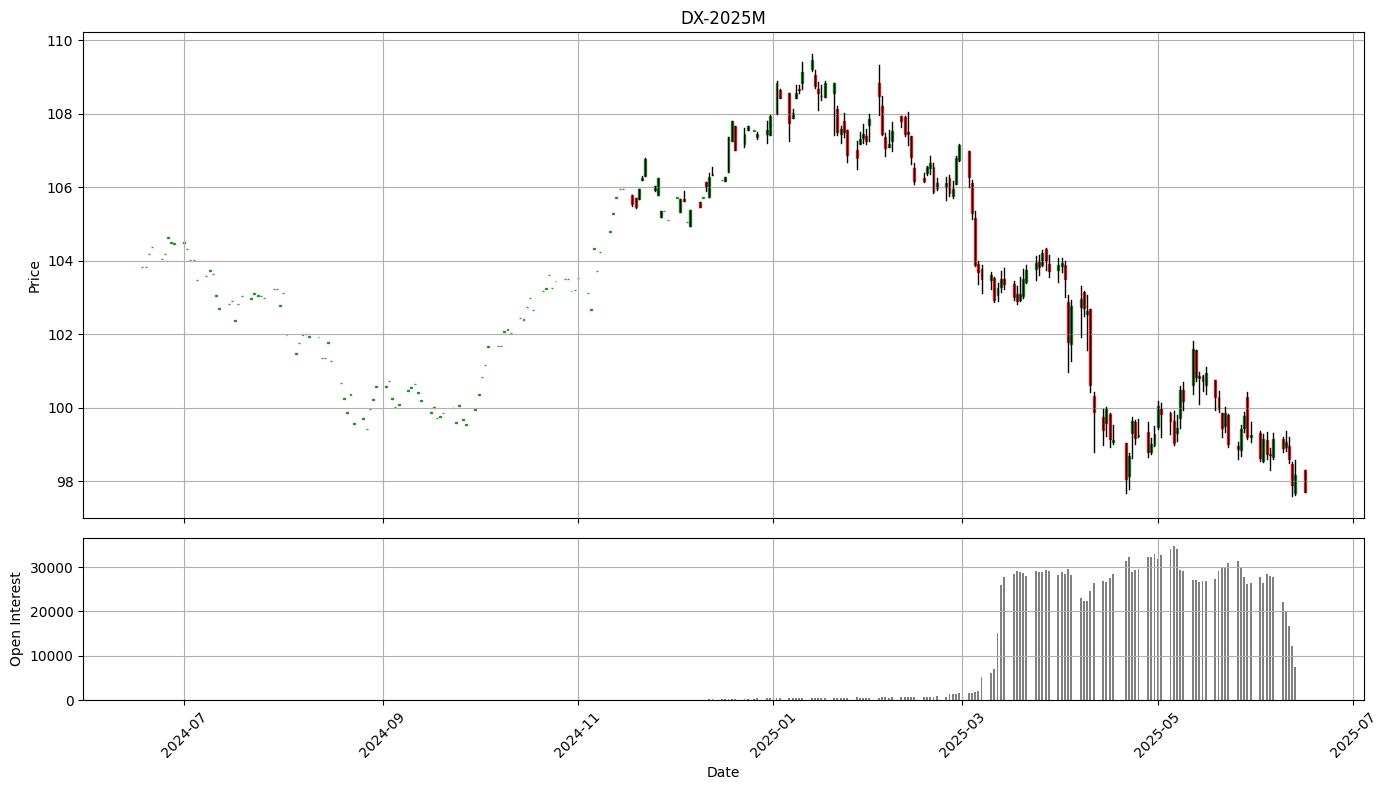

In [3]:
import norgatedata
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import pandas as pd

# Load data
symbol = 'DX-2025M'

df = norgatedata.price_timeseries(
    symbol,
    start_date='2020-01-01',
    end_date='2025-08-01',
    format='pandas-dataframe',
    stock_price_adjustment_setting=norgatedata.StockPriceAdjustmentType.NONE,
    padding_setting=norgatedata.PaddingType.NONE,
    timezone='UTC'
)

if df.empty:
    print(f"No data found for {symbol}")
else:
    # Drop rows with missing data
    df = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Open Interest'])

    # Reset index to access date as column
    df = df.copy()
    df['Date'] = pd.to_datetime(df.index)
    df['DateNum'] = mdates.date2num(df['Date'])  # Convert to matplotlib date numbers

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # --- CANDLESTICKS ---
    width = 0.6  # Width of the candle bodies
    color_up = 'green'
    color_down = 'red'

    for idx, row in df.iterrows():
        color = color_up if row['Close'] >= row['Open'] else color_down
        # Wick (High-Low)
        ax1.plot([row['DateNum'], row['DateNum']], [row['Low'], row['High']], color='black', linewidth=1)
        # Body (Open-Close) 
        lower = min(row['Open'], row['Close'])
        height = abs(row['Close'] - row['Open'])
        candle = Rectangle(
            (row['DateNum'] - width / 2, lower),
            width,
            height if height > 0 else 0.01,  # Avoid zero-height candles
            color=color,
            alpha=0.8
        )
        ax1.add_patch(candle)

    ax1.set_ylabel('Price')
    ax1.set_title(f'{symbol}')
    ax1.grid(True)

    # --- OPEN INTEREST ---
    ax2.bar(df['DateNum'], df['Open Interest'], width=0.6, color='gray')
    ax2.set_ylabel('Open Interest')
    ax2.set_xlabel('Date')
    ax2.grid(True)

    # Format x-axis as dates
    ax2.xaxis_date()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


_Figure 1 Single Contract - DX2025M_

Figure 2 shows several consecutive contracts. Liquidity rolls forward in a predictable cycle: from March into June, then into September, and so on. From a modeling perspective, each contract only matters while it is the most liquid. Outside that window, prices are not reliable.


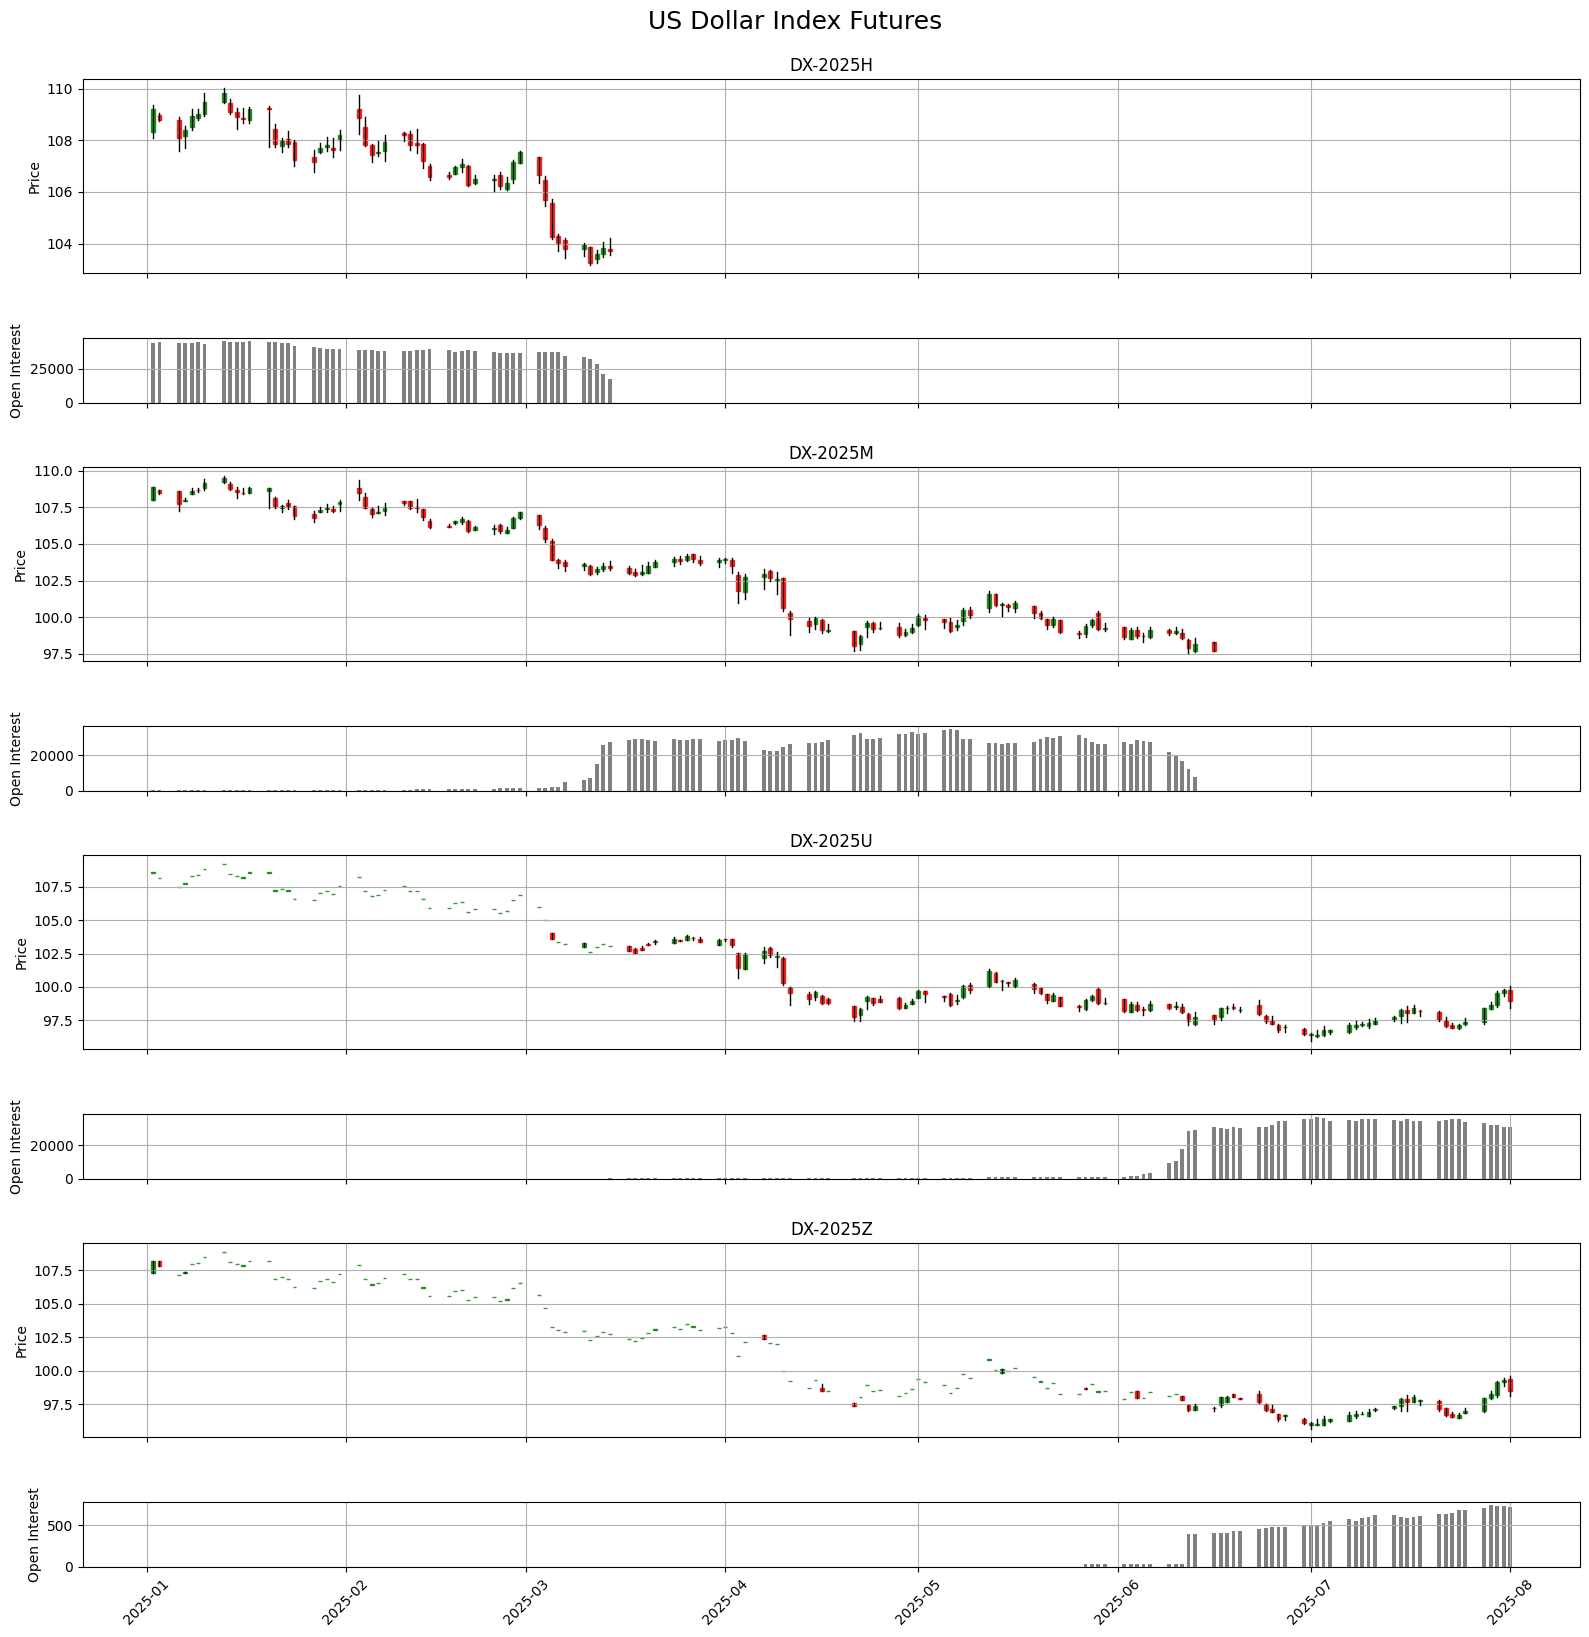

In [4]:
import norgatedata
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import pandas as pd

# Define your contract symbols
symbols = ['DX-2025H', 'DX-2025M', 'DX-2025U', 'DX-2025Z']
start_date = '2025-01-01'

# Matplotlib settings
plt.style.use('default')
fig, axes = plt.subplots(len(symbols) * 2, 1, figsize=(16, 16), sharex=True,
                         gridspec_kw={'height_ratios': [3, 1] * len(symbols)})

for i, symbol in enumerate(symbols):
    # Fetch data
    df = norgatedata.price_timeseries(
        symbol,
        start_date=start_date,
        end_date='2025-08-01',
        format='pandas-dataframe',
        stock_price_adjustment_setting=norgatedata.StockPriceAdjustmentType.NONE,
        padding_setting=norgatedata.PaddingType.NONE,
        timezone='UTC'
    )

    if df.empty:
        print(f"No data for {symbol}")
        continue

    # Prepare data
    df = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Open Interest']).copy()
    df['Date'] = pd.to_datetime(df.index)
    df['DateNum'] = mdates.date2num(df['Date'])

    # Axes for price and OI
    ax_price = axes[i * 2]
    ax_oi = axes[i * 2 + 1]

    # Plot candlesticks
    width = 0.6
    for _, row in df.iterrows():
        color = 'green' if row['Close'] >= row['Open'] else 'red'
        # Wick
        ax_price.plot([row['DateNum'], row['DateNum']], [row['Low'], row['High']], color='black', linewidth=1)
        # Body
        body = Rectangle(
            (row['DateNum'] - width / 2, min(row['Open'], row['Close'])),
            width,
            max(abs(row['Close'] - row['Open']), 0.01),
            color=color,
            alpha=0.8
        )
        ax_price.add_patch(body)

    ax_price.set_ylabel('Price')
    ax_price.set_title(f'{symbol}')
    ax_price.grid(True)

    # Plot Open Interest
    ax_oi.bar(df['DateNum'], df['Open Interest'], width=0.6, color='gray')
    ax_oi.set_ylabel('Open Interest')
    ax_oi.grid(True)

# Format date axis
axes[-1].xaxis_date()
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.suptitle('US Dollar Index Futures', fontsize=18, y=1.02)
plt.subplots_adjust(hspace=0.5)
plt.show()


_Figure 2 Liquidity Moving from Contract to Contract_

Figure 3 compares overlapping contracts. Prices differ between maturities on the same day. This is not random noise but the cost of carry: differences driven by funding, dividends, or storage depending on the asset. For this reason, comparing raw contract prices directly is misleading.

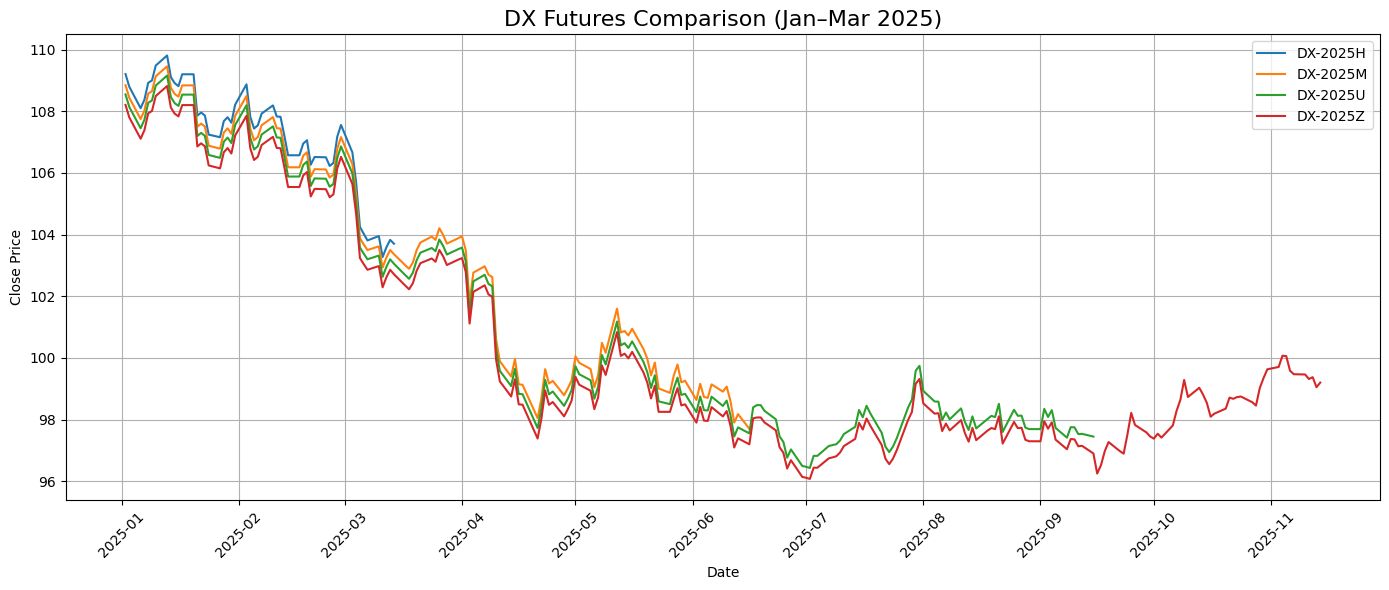

In [6]:
import norgatedata
import matplotlib.pyplot as plt
import pandas as pd

# Define contract symbols
symbols = ['DX-2025H', 'DX-2025M', 'DX-2025U', 'DX-2025Z']
start_date = '2025-01-01'
end_date = '2025-11-16'

# Create figure
plt.figure(figsize=(14, 6))

for symbol in symbols:
    # Fetch data
    df = norgatedata.price_timeseries(
        symbol,
        start_date=start_date,
        end_date=end_date,
        format='pandas-dataframe',
        stock_price_adjustment_setting=norgatedata.StockPriceAdjustmentType.NONE,
        padding_setting=norgatedata.PaddingType.NONE,
        timezone='UTC'
    )

    if df.empty:
        print(f"No data found for {symbol}")
        continue

    # Drop missing values and plot Close price
    df = df.dropna(subset=['Close'])
    plt.plot(df.index, df['Close'], label=symbol)

# Formatting
plt.title('DX Futures Comparison (Jan–Mar 2025)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


_Figure 3 Comparing Contracts_

If we simply stitch contracts together into one series without adjustment, we introduce artificial roll gaps. These jumps distort indicators and create false signals. In reality, rolling from one contract to the next in a portfolio would not generate that gain or loss.

The key point is that futures data must be handled differently from equities. A single uninterrupted price series does not exist, and treating it as if it does will distort both signals and risk estimates. Back-adjusted continuations are useful when we need a smooth history to calculate indicators, but they don’t reflect the actual prices a trader would have transacted. For execution modeling and realistic backtests, it is safer to work with individual contracts or dynamically rolled series that preserve true market prices.

### 5.1. Continuations and Zipline Behavior
To study long-term futures behavior, traders often build continuous contracts by linking individual delivery months into a single series. The most common method is back-adjustment: when the strategy rolls into a new contract, the historical prices are rescaled to remove the price gap. This produces a smooth history where percentage changes are preserved, which allows long-term indicators—like 200-day moving averages—to be calculated across multiple contracts.

The purpose of a back-adjusted series is not to replicate actual market prices, but to approximate the path a trader would have experienced if they had rolled positions at each expiry. It is therefore an analytical construct, not something that could ever be traded directly.

The drawback is that distortions accumulate over time. Each roll adjustment pushes the older history further away from real market prices, so the deeper we go back, the less the series resembles tradable levels. For example, in figure 4, a back-adjusted Cocoa series can show prices below zero even though the raw, unadjusted data never traded below 2,000 USD. Neither dataset is “wrong”; they simply serve different purposes.

Back-adjusted data is well-suited for studying returns, volatility, or relative performance. But it should not be used where actual price levels matter—such as position sizing, risk management, or comparisons with spot instruments. Another limitation is that most back-adjusted series are not static. Each new roll causes the entire history to be recalculated, meaning the same backtest run today may not match results from a year ago.

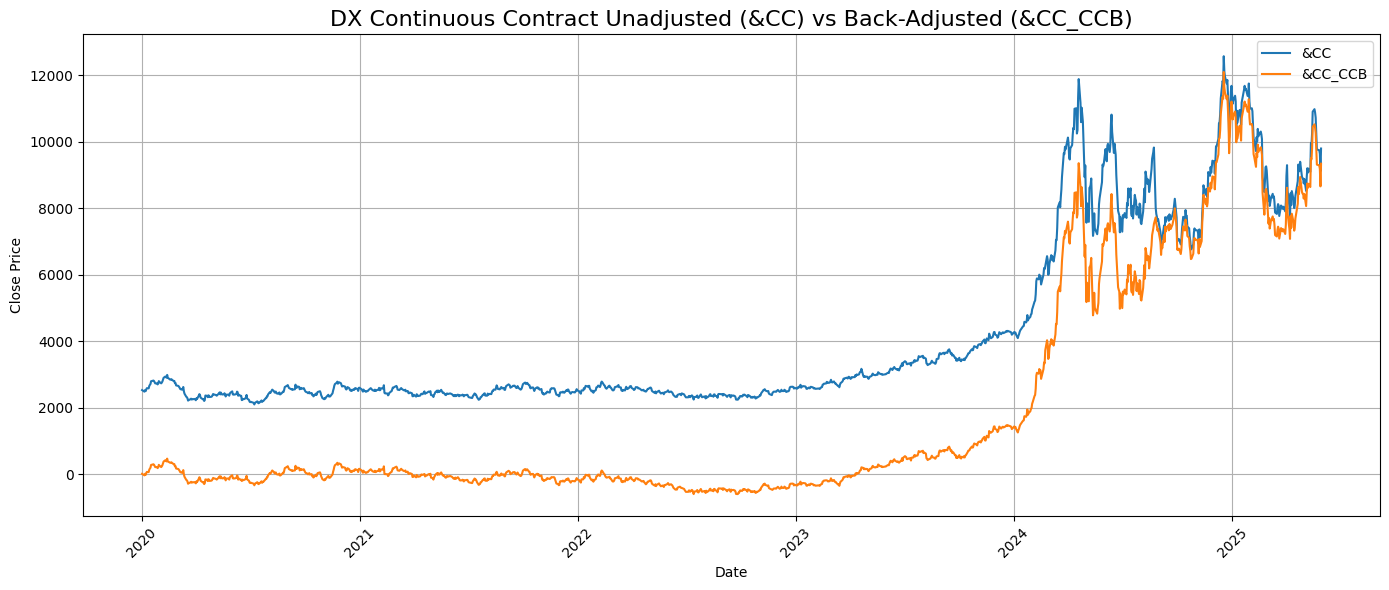

In [7]:
import norgatedata
import matplotlib.pyplot as plt
import pandas as pd

# Set date range
start_date = '2020-01-01'
end_date = '2025-06-01'

# Symbols to compare
symbols = ['&CC', '&CC_CCB']

# Create figure
plt.figure(figsize=(14, 6))

for symbol in symbols:
    # Fetch data
    df = norgatedata.price_timeseries(
        symbol,
        start_date=start_date,
        end_date=end_date,
        format='pandas-dataframe',
        stock_price_adjustment_setting=norgatedata.StockPriceAdjustmentType.NONE,  # Not needed for continuous contracts
        padding_setting=norgatedata.PaddingType.NONE,
        timezone='UTC'
    )

    if df.empty:
        print(f"No data for {symbol}")
        continue

    # Plot closing price
    plt.plot(df.index, df['Close'], label=symbol)

# Formatting
plt.title('DX Continuous Contract Unadjusted (&CC) vs Back-Adjusted (&CC_CCB)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


_Figure 4 Unadjusted versus Back-Adjusted Continuation_

To avoid these problems, this project relies on Zipline Reloaded’s continuation logic. Unlike most platforms, Zipline does not precompute continuations. Instead, it builds them dynamically, day by day during the backtest, using only information available up to that point in time. This prevents lookahead bias and mirrors what a trader would have seen in real time.

Equally important, Zipline never treats the continuation as a tradable instrument. Orders are always executed on the underlying individual contracts, exactly as they would be in the market. The continuation is only used for signal generation and indicator calculation, not for execution. This distinction avoids sizing or P&L errors that can occur if a strategy is tested directly on synthetic data.

The cost of this approach is complexity: to make this work, Zipline requires complete historical data for every individual contract—prices, volumes, expiry dates, multipliers, and auto-close rules. In this project, that amounts to tens of thousands of contracts across asset classes. But the gain in realism is significant. Continuations reflect actual liquidity, rolls are handled without forward bias, and strategies can be tested under conditions that closely resemble live trading.

### 5.2. Contracts, Continuations and Rolling in Zipline
The _roll_futures_ function manages the operational need to rotate expiring contracts into the front-month continuation. It is designed to act only when necessary and avoid interfering with the main strategy logic.

It begins by checking for any open orders. If a contract is already being traded, the function skips it to avoid conflicting instructions (e.g., simultaneous exit from the core logic and a forced roll).

For each contract currently held, the code calculates the number of trading days left until the contract’s _auto_close_date_. This date, provided by the data vendor (Norgate), usually occurs a few days before actual expiration to ensure liquidity and avoid delivery risk.

In [ ]:
def roll_futures(context, data): 
    open_orders = zipline.api.get_open_orders() 
    
    for held_contract in context.portfolio.positions: 
        # don't roll positions that are set to change by core logic
        if held_contract in open_orders: #if there's already an order in-flight, skip rolling to avoid conflict with your core trading logic
            continue
        
        # compute how many days are left until forced close
        days_to_auto_close = (
            held_contract.auto_close_date.date() - data.current_session.date()
        ).days

        #only roll contracts if they're 5 or fewer trading days from expiry, prevents unnecessary rolling
        if days_to_auto_close > 5:
            continue 

        continuation = continuous_future(
                held_contract.root_symbol, 
                offset=0, 
                roll='volume', 
                adjustment='mul'
                )

Only contracts with 5 or fewer trading days to expiry are eligible for rollover. This buffer avoids excessive rolling activity and ensures exits occur in an orderly manner.

If a position qualifies, a reference to the front-month contract is created using `continuous_future(...)`, which allows the strategy to align its logic with the new active contract.

In [ ]:
        # Pull the actual active futures contract from the continuation series
        continuation_contract = data.current(continuation, 'contract')
        
        if continuation_contract != held_contract:# If the current position is not in the new front contract, we need to roll it
            # Determine the number of contracts currently held in the expiring future
            pos_size = context.portfolio.positions[held_contract].amount         
            # Close current position
            order_target(held_contract, 0)
            # Open the same position size in the new active contract
            order_target(continuation_contract, pos_size) 

At this stage, the system checks if the current position is already in the front-month. If not, it closes the expiring contract and reopens the same position size in the new active one.

This approach ensures that the portfolio always holds liquid contracts, avoids expiry-related risks, and leaves the strategy’s core execution logic untouched.

In practice, these mechanics ensure that the backtest reflects how positions would have been managed in the market: contracts are rolled on time, liquidity is respected, and execution aligns with real tradable instruments. But once trades are modeled realistically, the next challenge is evaluating the strategy logic. For that, raw returns are not enough—we need a way to assess performance relative to risk. This sets the stage for introducing risk-adjusted metrics, with a particular focus on the Sortino Ratio.